In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from tkinter import Tk
from tkinter.filedialog import askdirectory
import itertools

#Defining the JM colours
JM_colours = {'dark blue':(30/235,34/235,170/235), 'light blue':(0,172/235,233/235), 'teal':(157/235,211/235,203/235), 'pink':(229/235,0,118/235), 'grey':(87/235,87/235,86/235)}

## Import the folder with .mpt files from EC Lab
User interactive:
1. Select the data folder which contains .mpt files with "CV" in the file name
2. Enter the electrode area (cm2)

In [2]:
#Open a Tkinter window to select the folder interactively
Tk().withdraw()
folder_path = askdirectory(title='Select Folder')

#Get user input for electrode area in cm²
electrode_area_cm2 = float(input("Enter the electrode area (cm²): "))

data_list = []

for file in os.listdir(folder_path):
    if file.endswith(".mpt") and "CV" in file:
        file_path = os.path.join(folder_path, file)
        with open(file_path, 'r', encoding='iso-8859-1') as f:
            lines = f.readlines()
            
            #Extract the column names from the header line
            header_line = lines[58].strip().split('\t')
            
            #Extract the data section
            data_start = 59
            data_lines = [line.strip().split('\t') for line in lines[data_start:]]
            
            #Create a dataframe for the data
            df_data = pd.DataFrame(data_lines, columns=header_line)
            
            #Create a dictionary or list of values for each file
            data = {
                'File': file,
                'Data': df_data
            }
            
            data_list.append(data)

df = pd.DataFrame(data_list)
#Accessing the data from the first .mpt file
first_file_data = df.loc[0, 'Data']

## Extract the relevant columns and clean the dataset

The following code merges all the data contained in the folder and creates a dataframe "result_df".

In [3]:
#Create an empty dataframe to store the extracted values
result_df = pd.DataFrame(columns=['File', 'Ewe/V', '<I>/mA'])

#Iterate over each dataframe in df
for i, row in df.iterrows():
    file_data = row['Data']
    file_name = row['File']
    
    #Accessing specific columns from each dataframe
    ewe_values = file_data['Ewe/V']
    current_values = file_data['<I>/mA']
    cycle_number = file_data['cycle number']
    
    #Create a temporary dataframe with the extracted values
    temp_df = pd.DataFrame({
        'File': [file_name] * len(ewe_values),
        'Ewe/V': ewe_values,
        '<I>/mA': current_values,
        'Cycle number': cycle_number
    })
    
    #Append the temporary dataframe to the result dataframe
    result_df = pd.concat([result_df, temp_df], ignore_index=True)

result_df['<I>/mA'] = result_df['<I>/mA'].astype(float) / electrode_area_cm2
result_df = result_df.rename(columns={'<I>/mA': '<I>/mAcm-2'})
result_df['Ewe/V'] = result_df['Ewe/V'].astype(float).round(2)

#Convert the cycle number column to float
result_df['Cycle number'] = result_df['Cycle number'].astype(float)

#Define a dictionary to map the current cycle numbers to the desired values
cycle_mapping = {1.0: 1, 2.0: 2, 3.0: 3}

#Replace the cycle numbers in the 'Cycle number' column
result_df['Cycle number'] = result_df['Cycle number'].replace(cycle_mapping)

#Print the updated dataframe
result_df.head()

,File,Ewe/V,<I>/mAcm-2,Cycle number
0,T23_CV_2_elect_Dark_Water_C02.mpt,-0.18,0.005109,1.0
1,T23_CV_2_elect_Dark_Water_C02.mpt,-0.18,0.010413,1.0
2,T23_CV_2_elect_Dark_Water_C02.mpt,-0.17,0.016478,1.0
3,T23_CV_2_elect_Dark_Water_C02.mpt,-0.17,0.020396,1.0
4,T23_CV_2_elect_Dark_Water_C02.mpt,-0.17,0.023528,1.0


The following code print a dataframe which contain the filenames of the folder and their index in the dictionary (it will be useful later).

In [4]:
unique_files = result_df['File'].unique()

#Create a dictionary to store the data
data = {
    'File': unique_files,
    'Dictionary Index': range(1, len(unique_files)+1)
}

#Create the dataframe
dictionary_df = pd.DataFrame(data)
dictionary_df

,File,Dictionary Index
0,T23_CV_2_elect_Dark_Water_C02.mpt,1
1,T23_CV_2_elect_Light_post_Dark_200rpm_Water_C0...,2
2,T23_CV_2_elect_Light_Water_C02.mpt,3
3,T23_CV_3_elect_Dark_200rpm_Water_2_C02.mpt,4
4,T23_CV_3_elect_Dark_200rpm_Water_C02.mpt,5
5,T23_CV_3_elect_Light_200rpm_Water_2_C02.mpt,6


## Dataset evaluation and Graph builder

The following function can be modified according to the user's needs (ask Sebastiano).

In [5]:
def apply_filters(df):
    """
    Applies filters to the given DataFrame based on user input.
    It contains two masks: 
    1. Selection of the cycle number: most CVs are run for more than
        one cycle, here the second one is selected.
    2. Selection of the potential range: CVs can be measured in different
        potential ranges, here the user can specify the min and max value
        of the range they would like to analyse
    
    Parameters:
        df (pandas.DataFrame): The DataFrame to filter
    
    Returns:
        pandas.DataFrame: The filtered DataFrame
    """
    
    #Get the last cycle number
    #last_cycle_number = df['Cycle number'].max()
    
    #Prompt the user to input the range for 'Ewe' values
    min_ewe = float(input("Enter the minimum 'Ewe' value: "))
    max_ewe = float(input("Enter the maximum 'Ewe' value: "))
    
    #Set the mask for Cycle number
    mask1 = df['Cycle number'] == 2
    #Set the mask for 'Ewe' values within the specified range
    mask2 = (df['Ewe/V'] >= min_ewe) & (df['Ewe/V'] <= max_ewe)
    
    #Apply the masks to filter the rows
    filtered_df = df[mask1 & mask2]
    
    return filtered_df

Here is an interactive graph builder, the user has to specify which data would like to plot (ref. dictionary_df to check the index of the dataframes dictionary). User inputs:
1. Index of results_df DataFrames dictionary
2. Minimum value for E<sub>we</sub> (Potential [V vs. RHE])
3. Maximum value for E<sub>we</sub> (Potential [V vs. RHE])
4. y/n selection for custom legend lables
5. Type the new label for customised legend
6. Repeat for all the data or type 'exit' to show the plot

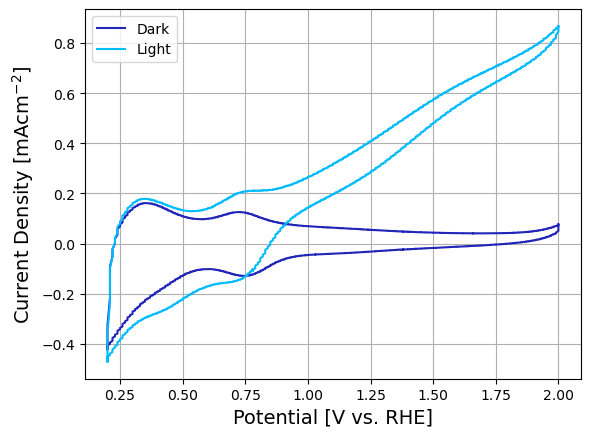

In [7]:
#Create an empty dictionary to store the dataframes
dataframes = {}

#Create an empty dictionary to store the legend handles
legend_handles = {}

#Create an iterator for cycling through colors
color_iterator = itertools.cycle(JM_colours.values())

#Iterate over the unique filenames
for i, file in enumerate(unique_files):
    #Filter the result_df based on the current filename
    filtered_df = result_df[result_df['File'] == file].copy()
    
    #Assign the filtered dataframe to a variable with a generic name
    var_name = f"df{i+1}"
    dataframes[var_name] = filtered_df

#Example: Accessing a specific dataframe
df1 = dataframes['df1']

#Interactive loop
plt.figure()  #Create a new figure
plt.xlabel('Potential [V vs. RHE]', fontsize = 14)
plt.ylabel('Current Density [$\mathregular{mAcm^{-2}}$]', fontsize = 14)

while True:
    #Prompt the user to input the dataframe index
    index = input("Enter the index of the dataframe (or 'exit' to quit): ")
    
    #Check if the user wants to exit
    if index.lower() == 'exit':
        break
    
    #Create the generic dataframe name
    dataframe_name = f"df{index}"
    
    #Check if the entered dataframe name exists in the dictionary
    if dataframe_name in dataframes:
        #Get the dataframe from the dictionary
        df = dataframes[dataframe_name]
        
        #Apply the filters to the dataframe
        filtered_df = apply_filters(df)
        
        #Get the color for the current dataframe/sample combination
        color = next(color_iterator)
        
        #Plotting Ewe/V versus <I>/mAcm-2 with the specified color
        line, = plt.plot(filtered_df['Ewe/V'], filtered_df['<I>/mAcm-2'], label=dataframe_name, color=color)
        
        #Store the line object as a legend handle
        legend_handles[dataframe_name] = line

    #Prompt the user to add custom legend labels
    add_legend_label = input("Add custom legend label? (y/n): ")

    if add_legend_label.lower() == 'n':
        continue #Skip the remaining code and move to the next iteration

    if add_legend_label.lower() == 'y':
        legend_label = input("Enter legend label: ")

        #Check if the entered dataframe name exists in the legend handles dictionary
        if dataframe_name in legend_handles:
            #Get the line object associated with the dataframe name
            line = legend_handles[dataframe_name]
            
            #Remove the dataframe name from the legend handles dictionary
            del legend_handles[dataframe_name]
            
            #Store the line object with the custom legend label
            legend_handles[legend_label] = line
            
            #Update the dataframe_name variable with the custom legend label
            dataframe_name = legend_label

#Show the legend with custom handles
legend_lines = [legend_handles[name] for name in legend_handles]
plt.legend(handles=legend_lines, labels=legend_handles.keys())

plt.grid(True)
plt.show()